In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.utils as vutils
import os
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import sys
from google.colab import drive
from torch.autograd import Variable
import matplotlib.pyplot as plt
import argparse

!nvidia-smi
!pip install torchvision==0.5.0
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
drive.mount('/content/gdrive')

Mon Nov 23 17:47:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !unzip 'gdrive/My Drive/colab/hw3/hw3_data.zip' -d 'gdrive/My Drive/colab/hw3/'
!unzip 'gdrive/My Drive/colab/hw3/hw3_data.zip'

串流輸出內容已截斷至最後 5000 行。
 extracting: hw3_data/face/train/27052.png  
 extracting: hw3_data/face/train/20371.png  
 extracting: hw3_data/face/train/05427.png  
 extracting: hw3_data/face/train/12436.png  
 extracting: hw3_data/face/train/26009.png  
 extracting: hw3_data/face/train/05878.png  
 extracting: hw3_data/face/train/06647.png  
 extracting: hw3_data/face/train/12449.png  
 extracting: hw3_data/face/train/02334.png  
 extracting: hw3_data/face/train/25609.png  
 extracting: hw3_data/face/train/36448.png  
 extracting: hw3_data/face/train/04737.png  
 extracting: hw3_data/face/train/12791.png  
 extracting: hw3_data/face/train/35307.png  
 extracting: hw3_data/face/train/27623.png  
 extracting: hw3_data/face/train/01046.png  
 extracting: hw3_data/face/train/02319.png  
 extracting: hw3_data/face/train/13551.png  
 extracting: hw3_data/face/train/30549.png  
 extracting: hw3_data/face/train/16949.png  
 extracting: hw3_data/face/train/33463.png  
 extracting: hw3_data/face/train/2

In [3]:
class Allen(Dataset): 
    def __init__(self, mode, transform = None):
        self.mode = mode
        self.transform = transform
        if self.mode == 'train':
          self.common_path = 'hw3_data/face/train/'
        else:
          self.common_path = 'hw3_data/face/test/'
        self.filename = sorted(os.listdir(self.common_path))
        self.len = len(self.filename)

    def __getitem__(self, index):
        path = os.path.join(self.common_path + str(self.filename[index]))
        im = Image.open(path)
        if self.transform is not None:
            im = self.transform(im)
        
        return im

    def __len__(self):

        return(self.len)

trainset = Allen('train', transform = transforms.ToTensor())
testset = Allen('test', transform = transforms.ToTensor())

train_loader = DataLoader(trainset, batch_size = 8, shuffle = True, drop_last = True)
test_loader = DataLoader(testset, batch_size = 1, drop_last = True)
print('訓練資料大小 : ',len(trainset))
print('測試資料大小 : ',len(testset))
print(trainset.__getitem__(2))

訓練資料大小 :  40000
測試資料大小 :  2621
tensor([[[0.3843, 0.3569, 0.3686,  ..., 0.1255, 0.1333, 0.1333],
         [0.3922, 0.3765, 0.3647,  ..., 0.1176, 0.1216, 0.1294],
         [0.3961, 0.3725, 0.3451,  ..., 0.1216, 0.1255, 0.1255],
         ...,
         [0.8314, 0.8353, 0.8275,  ..., 0.0941, 0.1020, 0.1020],
         [0.8314, 0.8471, 0.8353,  ..., 0.0941, 0.1020, 0.1059],
         [0.8118, 0.8314, 0.8235,  ..., 0.0941, 0.1059, 0.1020]],

        [[0.2471, 0.2235, 0.2431,  ..., 0.0863, 0.0863, 0.0902],
         [0.2510, 0.2431, 0.2392,  ..., 0.0824, 0.0863, 0.0980],
         [0.2510, 0.2431, 0.2196,  ..., 0.0863, 0.0902, 0.0902],
         ...,
         [0.6510, 0.6627, 0.6627,  ..., 0.0588, 0.0667, 0.0667],
         [0.6510, 0.6667, 0.6706,  ..., 0.0588, 0.0667, 0.0706],
         [0.6314, 0.6549, 0.6549,  ..., 0.0627, 0.0706, 0.0667]],

        [[0.2706, 0.2510, 0.2745,  ..., 0.1608, 0.1569, 0.1569],
         [0.2706, 0.2706, 0.2706,  ..., 0.1569, 0.1608, 0.1686],
         [0.2745, 0.2745, 0

In [4]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, inputSize, hiddenSize):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(inputSize, hiddenSize, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize, hiddenSize*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize*2, hiddenSize*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize*4, hiddenSize*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(hiddenSize*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())

    def forward(self, input):
        return self.main(input)

In [5]:
# Generator
class Generator(nn.Module):
    def __init__(self, inputSize, hiddenSize, outputSize):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(inputSize, hiddenSize*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(hiddenSize*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize*8, hiddenSize*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize*4, hiddenSize*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize*2, hiddenSize, 4, 2, 1, bias=False),
            nn.BatchNorm2d(hiddenSize),
            nn.ReLU(True),

            nn.ConvTranspose2d(hiddenSize, outputSize, 4, 2, 1, bias=False),
            nn.Tanh())

    def forward(self, input):
        return self.main(input)

In [6]:
# Weights
def weights_init(m):
    classname = m.__class__.__name__
    # print('classname:', classname)

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [7]:
# Train
def train():
    # Create the generator
    netG = Generator(G_in, G_hidden, G_out_D_in).to(device)
    netG.apply(weights_init)
    print(netG)

    # Create the discriminator
    netD = Discriminator(G_out_D_in, D_hidden).to(device)
    netD.apply(weights_init)
    print(netD)

    # Loss fuG_out_D_intion
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(64, G_in, 1, 1, device=device)

    real_label = 1
    fake_label = 0
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    print('Start!')
    for epoch in range(epochs):
        for i, data in enumerate(train_loader):
            # Update D network
            netD.zero_grad()
            real_cpu = data.to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, device=device)
            output = netD(real_cpu).view(-1)

            errD_real = criterion(output, label)
            errD_real.backward()
            D_x = output.mean().item()

            noise = torch.randn(b_size, G_in, 1, 1, device=device)
            fake = netG(noise)
            label.fill_(fake_label)
            output = netD(fake.detach()).view(-1)

            errD_fake = criterion(output, label)
            errD_fake.backward()

            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            optimizerD.step()

            # Update G network
            netG.zero_grad()
            label.fill_(real_label)
            output = netD(fake).view(-1)
            errG = criterion(output, label)
            errG.backward()
            D_G_z2 = output.mean().item()
            optimizerG.step()

            # Output training stats
            if i % 2500 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f' % (epoch+1, epochs, i, len(train_loader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == epochs - 1) and (i == len(train_loader) - 1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()

                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

    torch.save(netD, 'gdrive/My Drive/colab/hw3/problem2/netD_epoch5')
    torch.save(netG, 'gdrive/My Drive/colab/hw3/problem2/netG_epoch5')

    return G_losses, D_losses, img_list

In [8]:
# Plot
def plotImage(G_losses, D_losses):
    print('Start to plot!!')
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Grab a batch of real images from the dataloader
    real_batch = next(iter(train_loader))

    # Plot the real images
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(), (1, 2, 0)))

    # Plot the fake images from the last epoch
    plt.subplot(1, 2, 2)
    plt.axis("off")
    plt.title("Fake Images")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.show()

In [9]:
batch_size = 1024
image_size = 64
G_out_D_in = 3
G_in = 100
G_hidden = 64
D_hidden = 64

epochs = 5
lr = 0.001
beta1 = 0.5

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Start to plot!!


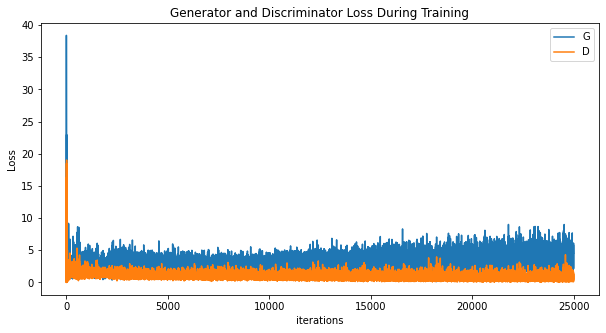

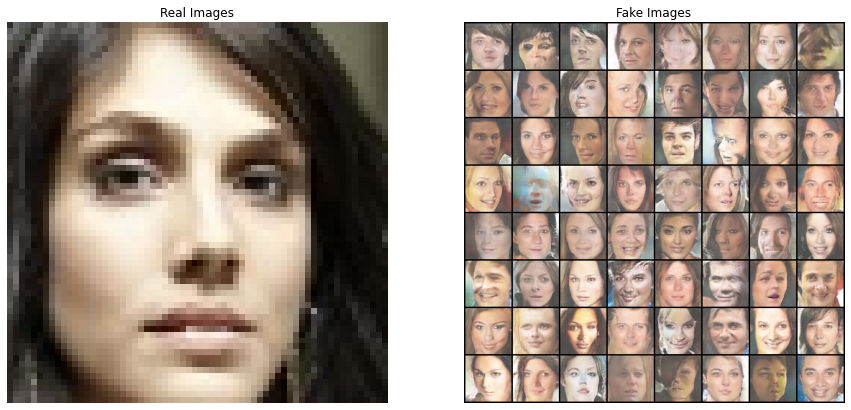

In [10]:
G_loss, D_loss, img_list = train()
plotImage(G_loss, D_loss)